In [1]:
from unity_dataset import UnityDataset

import os

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:

NUM_EPOCHS = 5
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

INPUT_IMAGE_DIR = "/media/blooker/Storage/gold-project-2021-images/480p/"

OUTPUT_IMAGE_DIR = "Data/Img"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
dataset = UnityDataset(INPUT_IMAGE_DIR, img_size=(480, 360), patch_size=(120, 120), transform=transform)

train_set, test_set = torch.utils.data.random_split(dataset, [302676, 27516])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

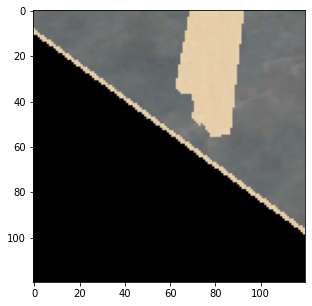

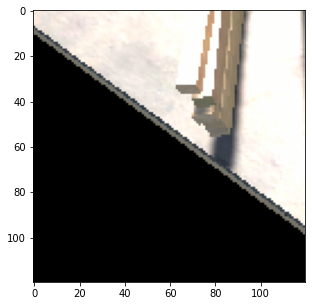

In [4]:
i = 302675

plt.figure(figsize=(15,5))

x, y = train_set[i]

img = x.permute(1,2,0)
plt.imshow(img)

plt.figure(figsize=(15,5))

img = y.permute(1,2,0)
plt.imshow(img)

In [5]:

def get_device():
    # if torch.cuda.is_available():
    #     device = "cuda:0"
    # else:
    #     device = "cpu"
    # return device

    return "cuda:0"

def make_dir():
    if not os.path.exists(OUTPUT_IMAGE_DIR):
        os.makedirs(OUTPUT_IMAGE_DIR)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 3, 120, 120)
    path = ("./" + OUTPUT_IMAGE_DIR + "/linear_ae_image{}.png").format(epoch)
    save_image(img, path)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, padding=1)

        # decoder
        self.dec1 = nn.ConvTranspose2d(in_channels=12, out_channels=24, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(in_channels=24, out_channels=24, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(in_channels=24, out_channels=3, kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.enc2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.enc3(x))
        code = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.dec1(code))

        x = F.relu(self.dec2(x))

        x = F.relu(self.dec3(x))

        return x

net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec1): ConvTranspose2d(12, 24, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(24, 24, kernel_size=(2, 2), stride=(2, 2))
  (dec3): ConvTranspose2d(24, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [8]:

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    device = get_device()
    for epoch in range(NUM_EPOCHS):
        start_time = time.perf_counter()
        running_loss = 0.0
        for data in trainloader:
            x,y = data
            # img = img.permute(0, 2, 3, 1)
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)

            optimizer.zero_grad()
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print("Epoch {} of {}, Train loss: {:.6f}, Time: {:.4f}".format(
            epoch+1, NUM_EPOCHS, loss, time.perf_counter()-start_time
        ))

        # if epoch % 5 == 0:
        save_decoded_image(outputs.cpu().data, epoch)

    return train_loss

In [9]:

def test_image_reconstruction(net, testloader):
    device = get_device()
    for batch in testloader:
        x, _ = batch
        x = x.to(device, dtype=torch.float)

        # img = img.view(img.size(0), -1)
        outputs = net(x)
        outputs = outputs.view(outputs.size(0), 3, 120, 120).cpu().data
        save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
        break

cuda:0
Epoch 1 of 5, Train loss: 0.034854, Time: 2064.8917
Epoch 2 of 5, Train loss: 0.024005, Time: 2030.3163
Epoch 3 of 5, Train loss: 0.022863, Time: 2012.9900
Epoch 4 of 5, Train loss: 0.022623, Time: 2016.7521
Epoch 5 of 5, Train loss: 0.022485, Time: 2038.9383


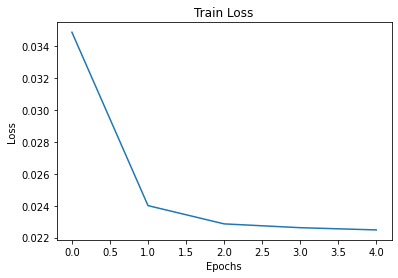

In [10]:

device = get_device()
print(device)

net.to(device)

make_dir()

train_loss = train(net, train_loader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./" + OUTPUT_IMAGE_DIR + "/deep_ae_loss.png")

In [11]:
test_image_reconstruction(net, test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012267049969523214


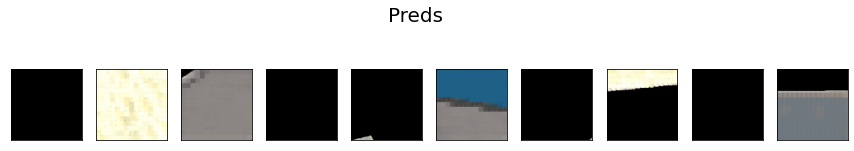

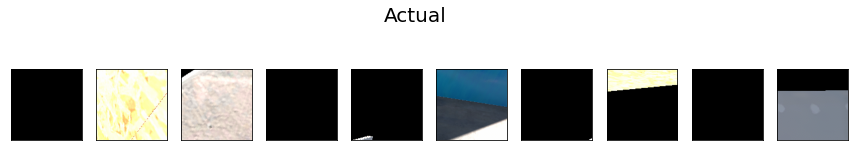

In [15]:
x_images = np.array([])
y_images = np.array([])

for batch in test_loader:
    x, y = batch
    x = x.to(device, dtype=torch.float)

    # img = img.view(img.size(0), -1)
    outputs = net(x)

    outputs = outputs.view(outputs.size(0), 3, 120, 120).cpu().data

    y_images = y
    x_images = outputs

    save_image(x, "./" + OUTPUT_IMAGE_DIR + '/unlit.png')
    save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
    save_image(y, "./" + OUTPUT_IMAGE_DIR + '/actual.png')
    break

print(timer)

def show_data(X, n=10, title=""):
    plt.figure(figsize=(15,5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = X[i].permute(1,2,0)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title, fontsize=20)

show_data(x_images, title="Preds")
show_data(y_images, title="Actual")

In [13]:
# Input to the model
x = torch.randn(1, 3, 256, 256)

net.cpu()

# Export the model
torch.onnx.export(net,                       # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "./Data/model.onnx",       # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,           # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['enc1'],       # the model's input names
                  output_names = ['dec3']       # the model's output names
                  )